In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode

1.4.0


In [2]:
# Reference:  https://medium.com/@vivekvscool/image-classification-cnn-with-pytorch-5b2cb9ef9476 
# Image classification — CNN with PyTorch
#Transformation for image
transform_ori = transforms.Compose([transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.RandomResizedCrop(64),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    # transforms.RandomResizedCrop(64),   #create 64x64 image
                                    # transforms.ToTensor(),                 #convert the image to a Tensor
#Load our dataset
train_dataset = datasets.ImageFolder(root = './train/',
                                     transform = transform_ori)
test_dataset = datasets.ImageFolder(root = './test/',
                                    transform = transform_ori)


#Make the dataset iterable
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)      #Shuffle to create a mixed batches of 100 of cat & dog images

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)
                                         
# #Show a batch of images
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.figure(figsize=(20,20))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
# dataiter = iter(train_load)
# # print (dataiter)
# images, labels = dataiter.next()
# # print (len(train_dataset))
# print (labels)

# # show images
# imshow(torchvision.utils.make_grid(images))

In [3]:
print(len(train_dataset[0]))
print(len(train_dataset[0][0]))
print(len(train_dataset[0][0][0]))
print(len(train_dataset[0][0][0][0]))

2
3
64
64


In [4]:
print ('There are {} images in the training set'.format (len(train_dataset)))
print ('There are {} images in the test set'.format (len(test_dataset)))
print ('There are {} batches in the train loader'.format(len(train_load)))
print ('There are {} batches in the testloader'.format(len(test_load)))

There are 8438 images in the training set
There are 1032 images in the test set
There are 85 batches in the train loader
There are 11 batches in the testloader


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # sub sampling - extract features
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 64/2 = 32
        
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 32/2 = 16
        
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)    #Size now is 16/2 = 8
        
        # fully connected - classification
        #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
        self.fc1 = nn.Linear(in_features=4096, out_features=4000)   #Flattened image is fed into linear NN and reduced to half size
        self.droput = nn.Dropout(p=0.5)                    #Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=4000, out_features=2000)
        self.droput = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=2000, out_features=500)
        self.droput = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(in_features=500, out_features=50)
        self.droput = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=50, out_features=2)   
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool3(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,4096)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc2(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc3(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc4(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc5(out)
        out = self.softmax(out)
        return out

In [6]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00006) # tune!

In [7]:
import time
from torch.autograd import Variable
num_epochs = 50

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    # change learning rate 
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
#         print ('train ' + str(iterations) )
#         print ('inputs' + str(inputs))
#         print ('labels' + str(labels))
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

#         # If we have GPU, shift the data to GPU
#         CUDA = torch.cuda.is_available()
#         if CUDA:
#             inputs = inputs.cuda()
#             labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data.item()      # Accumulate the loss, loss.data[0]
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
#     print ('train loss is '+ str(iter_loss))
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
    
    print ('Finish training.')
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.eval()                    # Put the network into evaluation mode
    for i, (inputs, labels) in enumerate(test_load):
#         print ('test ' + str(iterations) )
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)  
        
        loss = loss_fn(outputs, labels) # Calculate the loss
        iter_loss += loss.data.item() # loss.data[0]
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1
#     print ('test loss is '+ str(iter_loss))
    # Record the Testing loss
    test_loss.append(iter_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    stop = time.time()
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))

Finish training.
Epoch 1/50, Training Loss: 0.557, Training Accuracy: 74.000, Testing Loss: 0.499, Testing Acc: 81.000, Time: 250.0247881412506s
Finish training.
Epoch 2/50, Training Loss: 0.464, Training Accuracy: 84.000, Testing Loss: 0.437, Testing Acc: 87.000, Time: 241.47273802757263s
Finish training.
Epoch 3/50, Training Loss: 0.434, Training Accuracy: 87.000, Testing Loss: 0.421, Testing Acc: 88.000, Time: 256.47430515289307s
Finish training.
Epoch 4/50, Training Loss: 0.422, Training Accuracy: 88.000, Testing Loss: 0.408, Testing Acc: 89.000, Time: 248.23885798454285s
Finish training.
Epoch 5/50, Training Loss: 0.410, Training Accuracy: 89.000, Testing Loss: 0.405, Testing Acc: 90.000, Time: 247.30568599700928s
Finish training.
Epoch 6/50, Training Loss: 0.396, Training Accuracy: 91.000, Testing Loss: 0.391, Testing Acc: 91.000, Time: 241.44756698608398s
Finish training.
Epoch 7/50, Training Loss: 0.401, Training Accuracy: 90.000, Testing Loss: 0.388, Testing Acc: 92.000, Time:

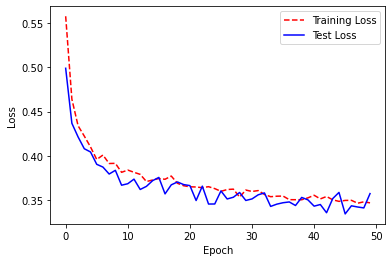

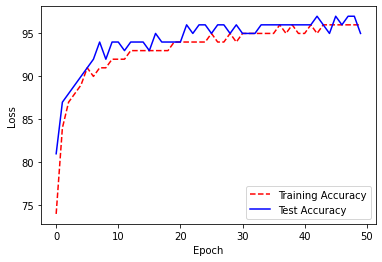

In [8]:
# Visualize loss history
plt.plot(list(range(50)), train_loss, 'r--')
plt.plot(list(range(50)), test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();
# Visualize accuracy history
plt.plot(list(range(50)), train_accuracy, 'r--')
plt.plot(list(range(50)), test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [9]:
modelPATH = './demo_images_95.pt'
torch.save(model, modelPATH)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
# 50+
#Training
for epoch in range(50,80): 
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    # change learning rate 
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
#         print ('train ' + str(iterations) )
#         print ('inputs' + str(inputs))
#         print ('labels' + str(labels))
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

#         # If we have GPU, shift the data to GPU
#         CUDA = torch.cuda.is_available()
#         if CUDA:
#             inputs = inputs.cuda()
#             labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data.item()      # Accumulate the loss, loss.data[0]
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
#     print ('train loss is '+ str(iter_loss))
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
    
    print ('Finish training.')
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.eval()                    # Put the network into evaluation mode
    for i, (inputs, labels) in enumerate(test_load):
#         print ('test ' + str(iterations) )
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)  
        
        loss = loss_fn(outputs, labels) # Calculate the loss
        iter_loss += loss.data.item() # loss.data[0]
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1
#     print ('test loss is '+ str(iter_loss))
    # Record the Testing loss
    test_loss.append(iter_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    stop = time.time()
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, 80, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))

Finish training.
Epoch 51/80, Training Loss: 0.381, Training Accuracy: 92.000, Testing Loss: 0.374, Testing Acc: 93.000, Time: 1012.727961063385s
Finish training.
Epoch 52/80, Training Loss: 0.377, Training Accuracy: 93.000, Testing Loss: 0.374, Testing Acc: 93.000, Time: 940.5655498504639s
Finish training.
Epoch 53/80, Training Loss: 0.379, Training Accuracy: 92.000, Testing Loss: 0.372, Testing Acc: 93.000, Time: 1035.1898410320282s
Finish training.
Epoch 54/80, Training Loss: 0.375, Training Accuracy: 93.000, Testing Loss: 0.367, Testing Acc: 94.000, Time: 1007.7251799106598s
Finish training.
Epoch 55/80, Training Loss: 0.376, Training Accuracy: 93.000, Testing Loss: 0.373, Testing Acc: 93.000, Time: 955.3806872367859s
Finish training.
Epoch 56/80, Training Loss: 0.374, Training Accuracy: 93.000, Testing Loss: 0.371, Testing Acc: 93.000, Time: 1038.9336099624634s
Finish training.
Epoch 57/80, Training Loss: 0.371, Training Accuracy: 93.000, Testing Loss: 0.379, Testing Acc: 92.000, 

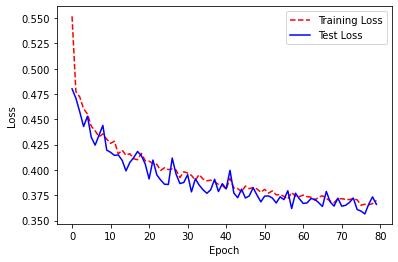

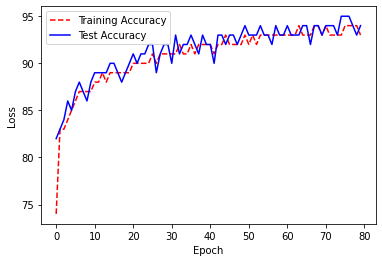

In [12]:
# Visualize loss history
plt.plot(list(range(80)), train_loss, 'r--')
plt.plot(list(range(80)), test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();
# Visualize accuracy history
plt.plot(list(range(80)), train_accuracy, 'r--')
plt.plot(list(range(80)), test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [13]:
modelPATH = './all_images_cnn_model_epoch80.pt'
torch.save(model, modelPATH)